In [1]:
import glob
import matplotlib.pyplot as plt
import pandas as pd
import datetime

%matplotlib inline

import abstract_reader


abstractlist = glob.glob("abstracts/*")

xml_elements = ['datecreated', 'title', 'articletitle', 'abstracttext', 'language',  'country', 'publicationstatus']

In [2]:
df = abstract_reader.create_df(abstractlist, xml_elements)

In [3]:
df.shape

(2653, 7)

In [4]:
df[:5]

,datecreated,title,articletitle,abstracttext,language,country,publicationstatus
0,2001-03-06,diabetes care,pioglitazone hydrochloride monotherapy improve...,evaluate efficacy safety four doses pioglitazo...,eng,united states,ppublish
1,1996-05-28,archives of general psychiatry,six-month follow-up naltrexone psychotherapy a...,goal study examine persistence naltrexone's ef...,eng,united states,ppublish
2,2003-10-27,diabetes care,treat-to-target trial: randomized addition gla...,compare abilities associated hypoglycemia risk...,eng,united states,ppublish
3,2001-05-04,clinical pediatrics,follow-up throat cultures necessary rapid anti...,frequency obtaining false-negative group strep...,eng,united states,ppublish
4,2006-11-08,acta obstetricia et gynecologica scandinavica,prevention postpartum hemorrhage uterotonic ag...,determine efficacy intravenous oxytocin admini...,eng,denmark,ppublish


# Publications by counry

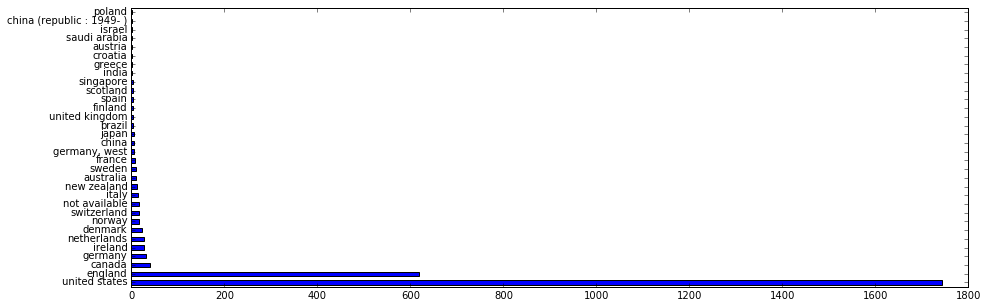

In [5]:
df['country'].value_counts().plot(kind='barh', figsize=(15, 5))

# Publication by language

In [6]:
df['language'].value_counts()

eng    2645
spa       3
dut       2
chi       1
fre       1
dan       1
Name: language, dtype: int64

# Publication by publication status

In [7]:
df['publicationstatus'].value_counts()

ppublish    2592
epublish      61
Name: publicationstatus, dtype: int64

# Publication by year of publication

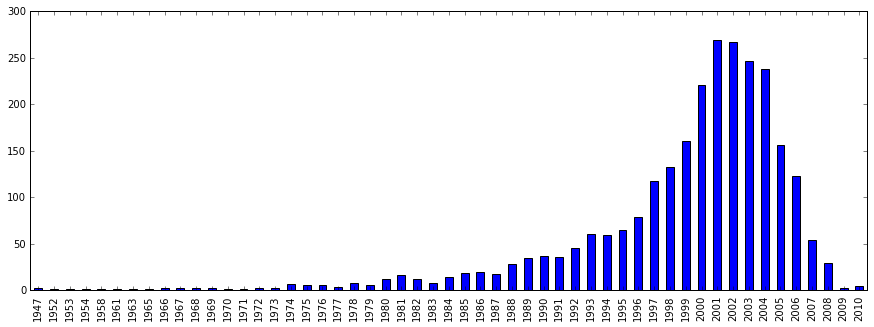

In [25]:
dates = pd.to_datetime(df.datecreated[df.datecreated != 'not available'])
dates.dt.year.value_counts().sort_index().plot(kind='bar', figsize=(15, 5))

In [ ]:
texts = df.abstracttext